In [1]:
state = 'LA'
level = 'blockgroup'
district_type = 'SS'  
minority = 'Black'
deviation = 0.10      # 0.10 means 10% means +/-5%

In [2]:
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.optimization import SingleMetricOptimizer, Gingleator
from gerrychain.tree import recursive_seed_part
from functools import partial
import pandas as pd
import json
from networkx.readwrite import json_graph
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random

random.seed(2024)

In [3]:
filepath = 'C://districting-data-2020//'
filename = state + '_' + level + ".json"
G = Graph.from_json(filepath+filename)

for i in G.nodes:
    G.nodes[i]['TOTPOP'] = G.nodes[i]['P0010001']

from number_of_districts import number_of_districts
k = number_of_districts[state,district_type]

total_population = sum( G.nodes[i]['TOTPOP'] for i in G.nodes )
ideal_population = total_population / k
import math
L = math.ceil( ideal_population * (1-deviation/2) )
U = math.floor( ideal_population * (1+deviation/2) )

print("Effectively using k, L, U =",k,L,U)

Effectively using k, L, U = 39 113459 125401


In [4]:
from district import get_census_codes
codes = get_census_codes(minority)
        
for i in G.nodes:
    G.nodes[i]['VAP'] = G.nodes[i]['P0030001']
    G.nodes[i]['MVAP'] = sum( G.nodes[i][code] for code in codes )

In [5]:
chain_updaters = {
"population": updaters.Tally("TOTPOP", alias="population"),
"VAP": updaters.Tally("VAP"),
"MVAP": updaters.Tally("MVAP")
}

initial_partition = Partition.from_random_assignment(
    graph=G,
    n_parts=k,
    epsilon=deviation/2,
    pop_col="TOTPOP",
    updaters=chain_updaters
)

proposal = partial(
    proposals.recom,
    pop_col="TOTPOP",
    pop_target=ideal_population,
    epsilon=deviation/2,
    node_repeats=1
)

constraints = constraints.within_percent_of_ideal_population(initial_partition, deviation/2)

In [6]:
gingles = Gingleator(
    proposal,
    constraints,
    initial_partition,
    minority_pop_col="MVAP",
    total_pop_col="VAP",
    score_function=Gingleator.reward_partial_dist
)

In [15]:
from metrics import number_of_counties_split, number_of_county_splits, average_polsby_popper
total_steps = 100000

# Short Bursts
max_scores_sb = np.zeros(total_steps)
scores_sb = np.zeros(total_steps)
pp = np.zeros(total_steps)
s1 = np.zeros(total_steps)
s2 = np.zeros(total_steps)
for i, part in enumerate(gingles.short_bursts(10, 10000, with_progress_bar=True)):
    max_scores_sb[i] = gingles.best_score
    scores_sb[i] = gingles.score(part)
    districts = [ list() for j in range(k) ]
    for v in G.nodes:
        j = part.assignment[v]
        districts[j].append(v)
    s1[i] = number_of_counties_split(G, districts)
    s2[i] = number_of_county_splits(G, districts)
    pp[i] = average_polsby_popper(G, districts)

# # Simulated Annealing
# max_scores_anneal = np.zeros(total_steps)
# scores_anneal = np.zeros(total_steps)
# for i, part in enumerate(
#     gingles.simulated_annealing(
#         total_steps,
#         gingles.jumpcycle_beta_function(1000, 4000),
#         beta_magnitude=500,
#         with_progress_bar=True
#     )
# ):
#     max_scores_anneal[i] = gingles.best_score
#     scores_anneal[i] = gingles.score(part)

# # Tilted Runs
# max_scores_tilt = np.zeros(total_steps)
# scores_tilt = np.zeros(total_steps)
# for i, part in enumerate(gingles.tilted_run(total_steps, 0.125, with_progress_bar=True)):
#     max_scores_tilt[i] = gingles.best_score
#     scores_tilt[i] = gingles.score(part)

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [1:09:27<00:00, 23.99it/s]


In [16]:
print("i gingles pp s1 s2")
for i in range(total_steps):
    if i%100==0:
        print(i,round(scores_sb[i], 4), round(pp[i],4), round(s1[i]), round(s2[i]))

i gingles pp s1 s2
0 4.4587 0.2014 50 105
100 6.4732 0.2066 49 102
200 6.4755 0.2236 45 98
300 7.4386 0.2226 50 101
400 8.4391 0.2293 51 102
500 8.4897 0.2214 51 103
600 8.4897 0.2116 53 102
700 8.4897 0.2257 53 105
800 8.4897 0.2187 51 105
900 8.4897 0.2148 50 106
1000 9.3881 0.2127 49 105
1100 9.4076 0.2096 51 110
1200 9.4076 0.1845 51 116
1300 9.4076 0.1852 53 112
1400 9.4117 0.2101 53 104
1500 9.4791 0.2018 53 106
1600 9.4791 0.2029 54 105
1700 9.4893 0.1928 53 104
1800 9.4893 0.1916 55 102
1900 9.4893 0.1949 49 103
2000 9.4893 0.1943 52 105
2100 9.4893 0.1835 53 108
2200 9.4893 0.1888 54 108
2300 9.4893 0.1877 53 108
2400 9.4893 0.1951 52 102
2500 9.4893 0.2075 51 98
2600 9.4893 0.2015 51 104
2700 9.4893 0.2076 52 108
2800 9.4893 0.208 49 100
2900 9.4983 0.2137 52 105
3000 9.4983 0.2069 51 103
3100 9.4983 0.2069 52 106
3200 9.4983 0.1949 48 104
3300 9.4983 0.1999 46 103
3400 9.4983 0.2152 48 105
3500 9.4983 0.2121 51 109
3600 9.4983 0.2209 47 103
3700 9.4983 0.2198 50 103
3800 9.4

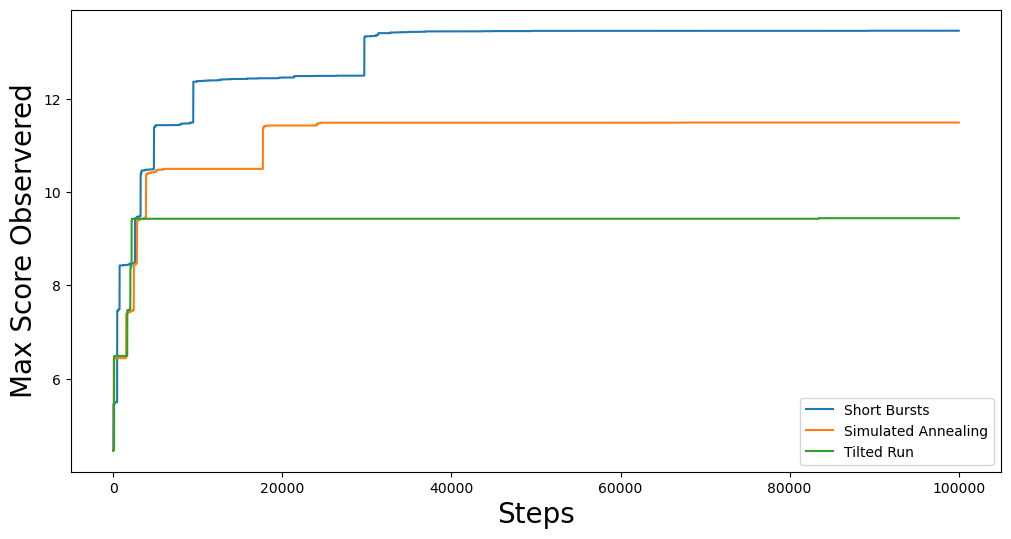

In [10]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(max_scores_sb, label="Short Bursts")
plt.plot(max_scores_anneal, label="Simulated Annealing")
plt.plot(max_scores_tilt, label="Tilted Run")
plt.xlabel("Steps", fontsize=20)
plt.ylabel("Max Score Observered", fontsize=20)
plt.legend()
plt.show()

In [11]:
max( max_scores_sb )

13.459311808736453